In [22]:
pip install pyspark pandas matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Создание SparkSession
spark = SparkSession.builder \
    .appName("Economic Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

In [25]:
# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/user5/hadoop/input/economic_data/rejected_2007_to_2018Q4.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True, sep=",", encoding ="utf-8")

# Просмотр первых строк данных
df.show(5)

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+--------------------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Policy Code;;;;;;;;;|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+--------------------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                 10%|   481xx|   NM|          4 years|        0.0;;;;;;;;;|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                 10%|   010xx|   MA|         < 1 year|        0.0;;;;;;;;;|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                 10%|   212xx|   MD|           1 year|        0.0;;;;;;;;;|
|          6000.0|      2007-05-27|             waksman|     698.0|              38.64%|   017xx|   MA|         < 1 year|        0.0;;;;;;;;;|

## Очистка и нормализация данных

In [26]:
# Удаляем несколько столбцов
columns_to_drop = ["Policy Code;;;;;;;;;"]

df_cleaned = df.drop(*columns_to_drop)

# Показываем обновленный DataFrame
df_cleaned.show(5)

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                 10%|   481xx|   NM|          4 years|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                 10%|   010xx|   MA|         < 1 year|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                 10%|   212xx|   MD|           1 year|
|          6000.0|      2007-05-27|             waksman|     698.0|              38.64%|   017xx|   MA|         < 1 year|
|          1500.0|      2007-05-27|              mdrigo|     509.0|               9.43%|   209xx|   MD|         < 1 year|
+----------------+------

In [27]:
df_cleaned.printSchema()

root
 |-- Amount Requested: string (nullable = true)
 |-- Application Date: string (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Risk_Score: string (nullable = true)
 |-- Debt-To-Income Ratio: string (nullable = true)
 |-- Zip Code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Employment Length: string (nullable = true)



In [28]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

# 1. Проверка пропусков (NULL и NaN) с учетом типов данных
null_check_exprs = []
for col_name in df_cleaned.columns:
    col_type = df_cleaned.schema[col_name].dataType
    if isinstance(col_type, NumericType):
        # Для числовых столбцов: проверяем и NaN, и NULL
        expr = F.count(F.when(F.isnan(col_name) | F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))
    else:
        # Для нечисловых: только NULL
        expr = F.count(F.when(F.isnull(col_name), col_name))
        null_check_exprs.append(expr.alias(f"{col_name}_nulls"))

null_check = df_cleaned.select(*null_check_exprs)
null_check.show(vertical=True)


-RECORD 0----------------------------
 Amount Requested_nulls     | 0      
 Application Date_nulls     | 26     
 Loan Title_nulls           | 113    
 Risk_Score_nulls           | 266867 
 Debt-To-Income Ratio_nulls | 13     
 Zip Code_nulls             | 55     
 State_nulls                | 47     
 Employment Length_nulls    | 22402  



In [32]:
from pyspark.sql.functions import col, regexp_replace, when, lit, to_date

In [48]:
# Удаление строк с пустыми значениями
df1 = df_cleaned.dropna()

# Преобразование Risk_Score в числовой формат
df2 = df1.withColumn("Risk_Score", col("Risk_Score").cast("double"))

# Убираем символ % из Debt-To-Income Ratio и делаем его числом
df3 = df2.withColumn("Debt-To-Income Ratio", 
                   regexp_replace(col("Debt-To-Income Ratio"), "%", "").cast("double"))

df4 = df3.withColumn("Amount Requested", 
                      regexp_replace(col("Amount Requested"), "[,$₽€]", "").cast("double"))

# Создаем целевую переменную: дефолт, если Risk_Score < 600
df_final = df4.withColumn("Default", 
                           when(col("Risk_Score") < 600, lit(1)).otherwise(lit(0)))
df_final.show(5)

+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-------+
|Amount Requested|Application Date|          Loan Title|Risk_Score|Debt-To-Income Ratio|Zip Code|State|Employment Length|Default|
+----------------+----------------+--------------------+----------+--------------------+--------+-----+-----------------+-------+
|          1000.0|      2007-05-26|Wedding Covered b...|     693.0|                10.0|   481xx|   NM|          4 years|      0|
|          1000.0|      2007-05-26|  Consolidating Debt|     703.0|                10.0|   010xx|   MA|         < 1 year|      0|
|         11000.0|      2007-05-27|Want to consolida...|     715.0|                10.0|   212xx|   MD|           1 year|      0|
|          6000.0|      2007-05-27|             waksman|     698.0|               38.64|   017xx|   MA|         < 1 year|      0|
|          1500.0|      2007-05-27|              mdrigo|     509.0|                9.43|  

In [49]:
# 3. Переименование столбцов на русский язык
translated_df = df_final.withColumnRenamed("Amount Requested", "Запрашиваемая сумма") \
                  .withColumnRenamed("Application Date", "Дата подачи заявки") \
                  .withColumnRenamed("Loan Title", "Назначение кредита") \
                  .withColumnRenamed("Risk_Score", "Кредитный рейтинг") \
                  .withColumnRenamed("Debt-To-Income Ratio", "Долговая нагрузка (%)") \
                  .withColumnRenamed("Zip Code", "Почтовый индекс") \
                  .withColumnRenamed("State", "Штат") \
                  .withColumnRenamed("Employment Length", "Срок занятости") 

In [50]:
df6 = translated_df.toPandas()
df6.head(5)

,Запрашиваемая сумма,Дата подачи заявки,Назначение кредита,Кредитный рейтинг,Долговая нагрузка (%),Почтовый индекс,Штат,Срок занятости,Default
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10.00,481xx,NM,4 years,0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10.00,010xx,MA,< 1 year,0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10.00,212xx,MD,1 year,0
3,6000.0,2007-05-27,waksman,698.0,38.64,017xx,MA,< 1 year,0
4,1500.0,2007-05-27,mdrigo,509.0,9.43,209xx,MD,< 1 year,1


In [53]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771938 entries, 0 to 771937
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Запрашиваемая сумма    770858 non-null  float64       
 1   Дата подачи заявки     770858 non-null  datetime64[ns]
 2   Назначение кредита     771938 non-null  object        
 3   Кредитный рейтинг      771034 non-null  float64       
 4   Долговая нагрузка (%)  771054 non-null  float64       
 5   Почтовый индекс        771938 non-null  object        
 6   Штат                   771938 non-null  object        
 7   Срок занятости         771938 non-null  object        
 8   Default                771938 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), object(4)
memory usage: 50.1+ MB


In [52]:
df6['Дата подачи заявки'] = pd.to_datetime(df6['Дата подачи заявки'], errors='coerce')

In [54]:
# Преобразование Pandas DataFrame обратно в PySpark DataFrame
data_spark = spark.createDataFrame(df6)

25/06/01 19:30:58 WARN TaskSetManager: Stage 22 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


   Default   count
0        0  529292
1        1  242646


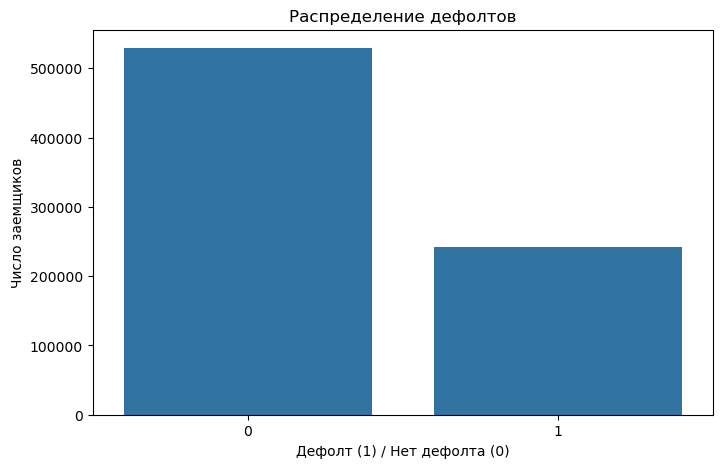

In [55]:
#Анализ кредитного риска
default_counts = data_spark.groupBy("Default").count().toPandas()
print(default_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x="Default", y="count", data=default_counts)
plt.title("Распределение дефолтов")
plt.xlabel("Дефолт (1) / Нет дефолта (0)")
plt.ylabel("Число заемщиков")
plt.show()

25/06/01 19:36:55 WARN TaskSetManager: Stage 25 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


                       Кредитный рейтинг  Долговая нагрузка (%)
Кредитный рейтинг               1.000000              -0.004221
Долговая нагрузка (%)          -0.004221               1.000000


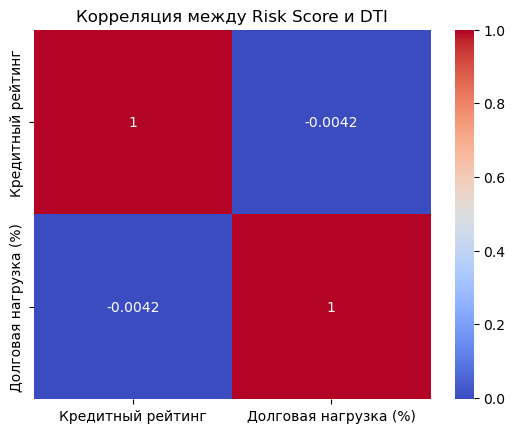

In [56]:
#Корреляция между риском и долговой нагрузкой
corr_data = data_spark.select("Кредитный рейтинг", "Долговая нагрузка (%)").toPandas()
corr = corr_data.corr()
print(corr)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Корреляция между Risk Score и DTI")
plt.show()

In [61]:
data_spark.printSchema()

root
 |-- Запрашиваемая сумма: double (nullable = true)
 |-- Дата подачи заявки: timestamp (nullable = true)
 |-- Назначение кредита: string (nullable = true)
 |-- Кредитный рейтинг: double (nullable = true)
 |-- Долговая нагрузка (%): double (nullable = true)
 |-- Почтовый индекс: string (nullable = true)
 |-- Штат: string (nullable = true)
 |-- Срок занятости: string (nullable = true)
 |-- Default: long (nullable = true)



## Сегментация 

25/06/01 20:05:01 WARN TaskSetManager: Stage 31 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


  Уровень риска   count
0       Средний  399855
1        Низкий  242646
2       Высокий  129437


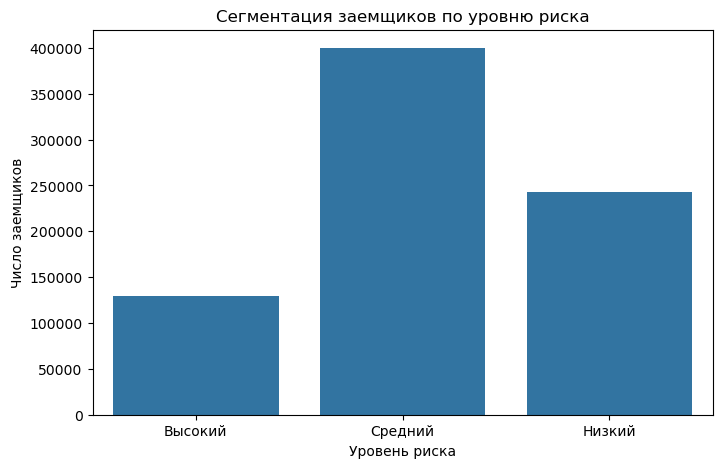

In [66]:
#Сегментация заемщиков
segments = data_spark.withColumn("Уровень риска",
                         when(col("Кредитный рейтинг") >= 700, "Высокий")
                         .when(col("Кредитный рейтинг") >= 600, "Средний")
                         .otherwise("Низкий"))

segment_counts = segments.groupBy("Уровень риска").count().toPandas()
print(segment_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x="Уровень риска", y="count", data=segment_counts,
            order=["Высокий", "Средний", "Низкий"])
plt.title("Сегментация заемщиков по уровню риска")
plt.xlabel("Уровень риска")
plt.ylabel("Число заемщиков")
plt.show()

25/06/01 20:05:49 WARN TaskSetManager: Stage 34 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


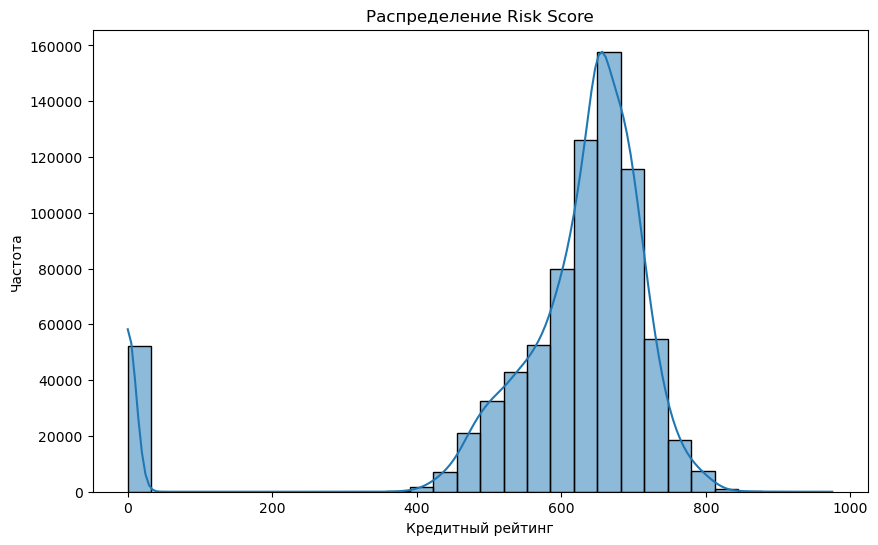

In [67]:
#Визуализация распределения Risk Score
risk_scores = data_spark.select("Кредитный рейтинг").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(risk_scores, x="Кредитный рейтинг", bins=30, kde=True)
plt.title("Распределение Risk Score")
plt.xlabel("Кредитный рейтинг")
plt.ylabel("Частота")
plt.show()

In [68]:
# Путь в HDFS для сохранения
finaly_date = "hdfs://localhost:9000/user5/hadoop/input/economic_data/finaly_data.csv"

# Сохранение DataFrame в формате CSV в HDFS
data_spark.write.csv(finaly_date, header=True, mode='overwrite')

25/06/01 20:10:07 WARN TaskSetManager: Stage 35 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


In [69]:
pandas_df = data_spark.toPandas()
pandas_df.head()

25/06/01 20:11:47 WARN TaskSetManager: Stage 36 contains a task of very large size (30405 KiB). The maximum recommended task size is 1000 KiB.


,Запрашиваемая сумма,Дата подачи заявки,Назначение кредита,Кредитный рейтинг,Долговая нагрузка (%),Почтовый индекс,Штат,Срок занятости,Default
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10.00,481xx,NM,4 years,0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10.00,010xx,MA,< 1 year,0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10.00,212xx,MD,1 year,0
3,6000.0,2007-05-27,waksman,698.0,38.64,017xx,MA,< 1 year,0
4,1500.0,2007-05-27,mdrigo,509.0,9.43,209xx,MD,< 1 year,1


In [71]:
pandas_df.describe()

,Запрашиваемая сумма,Дата подачи заявки,Кредитный рейтинг,Долговая нагрузка (%),Default
count,7.708580e+05,770858,771034.000000,7.710540e+05,771938.000000
mean,1.311530e+04,2011-11-26 07:45:43.499841024,593.358283,5.821708e+02,0.314334
min,5.000000e+02,2007-05-26 00:00:00,0.000000,-1.000000e+00,0.000000
25%,5.000000e+03,2011-01-30 00:00:00,575.000000,6.190000e+00,0.000000
50%,1.000000e+04,2011-12-15 00:00:00,643.000000,1.726000e+01,0.000000
75%,2.000000e+04,2012-08-29 00:00:00,684.000000,3.115000e+01,1.000000
max,1.400000e+06,2016-04-23 00:00:00,975.000000,5.000003e+07,1.000000
std,1.080044e+04,NaN,174.680666,5.915118e+04,0.464250


In [70]:
pandas_df.to_csv('/home/devops/Downloads/var2.csv', index=False, encoding='utf-8')